In [1]:
from sklearn.datasets import fetch_openml

# Step 1: Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Step 2: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Train Logistic Regression model
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9155


=== Cross-Validation Performance (ROC AUC) ===
LogisticRegression   | mean AUC: 0.9944
LogisticRegression   | mean AUC: 0.9963
LogisticRegression   | mean AUC: 0.9953
LogisticRegression   | mean AUC: 0.9918
LogisticRegression   | mean AUC: 0.9874
SVM (RBF)            | mean AUC: 0.9912
SVM (RBF)            | mean AUC: 0.9852
SVM (RBF)            | mean AUC: 0.9662
SVM (RBF)            | mean AUC: 0.9954
SVM (RBF)            | mean AUC: 0.9929
SVM (RBF)            | mean AUC: 0.9662
SVM (RBF)            | mean AUC: 0.9961
SVM (RBF)            | mean AUC: 0.9861
SVM (RBF)            | mean AUC: 0.9657
RandomForest         | mean AUC: 0.9885
RandomForest         | mean AUC: 0.9908
RandomForest         | mean AUC: 0.9912
RandomForest         | mean AUC: 0.9884
RandomForest         | mean AUC: 0.9886
GradientBoosting     | mean AUC: 0.9798
GradientBoosting     | mean AUC: 0.9861
GradientBoosting     | mean AUC: 0.9813
GradientBoosting     | mean AUC: 0.9915
GradientBoosting     | mean AUC: 

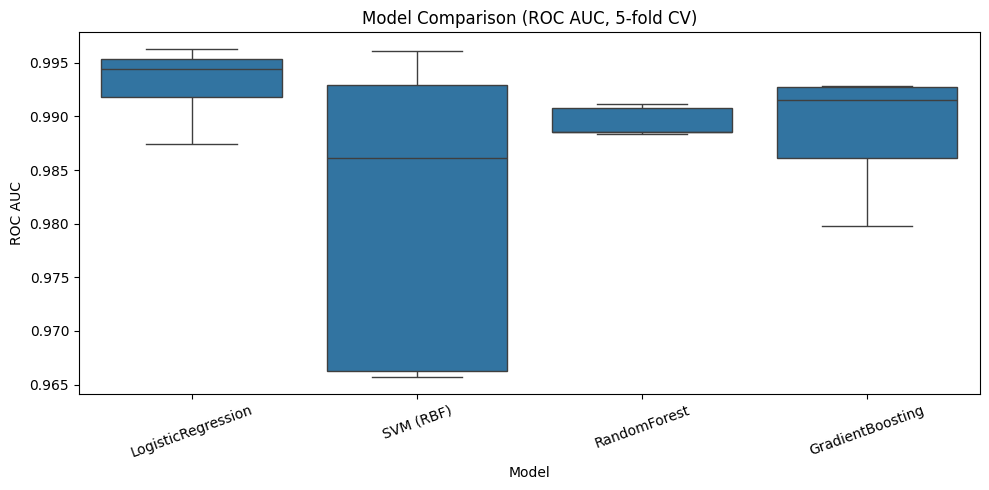

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# データ読み込み
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# 標準化
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 交差検証設定
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 各モデルとハイパーパラメータ設定
models = {
    'LogisticRegression': [
        LogisticRegression(C=c, penalty='l2', solver='liblinear') for c in [0.01, 0.1, 1, 10, 100]
    ],
    'SVM (RBF)': [
        SVC(C=c, gamma=g, kernel='rbf', probability=True) for c in [0.1, 1, 10] for g in [0.01, 0.1, 1]
    ],
    'RandomForest': [
        RandomForestClassifier(n_estimators=100, max_depth=d, random_state=42) for d in [2, 4, 6, 8, None]
    ],
    'GradientBoosting': [
        GradientBoostingClassifier(n_estimators=100, learning_rate=lr, max_depth=d, random_state=42)
        for lr in [0.01, 0.1, 0.2] for d in [2, 3, 4]
    ]
}

# 結果保存
results = []

print("=== Cross-Validation Performance (ROC AUC) ===")
for name, model_list in models.items():
    for model in model_list:
        scores = cross_val_score(model, X_std, y, cv=cv, scoring='roc_auc')
        results.append((name, str(model.get_params()), np.mean(scores)))
        print(f"{name:20s} | mean AUC: {np.mean(scores):.4f}")

# グラフ化（平均スコアの比較）
import pandas as pd

df_results = pd.DataFrame(results, columns=["Model", "Params", "ROC AUC"])
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_results, x="Model", y="ROC AUC")
plt.title("Model Comparison (ROC AUC, 5-fold CV)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


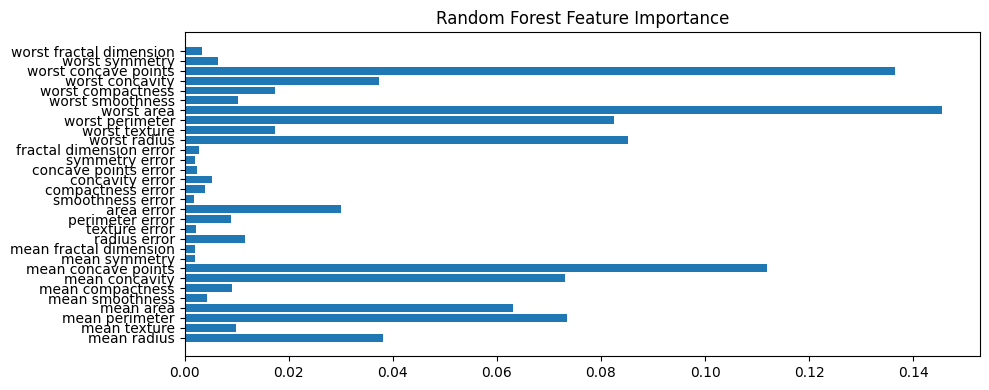

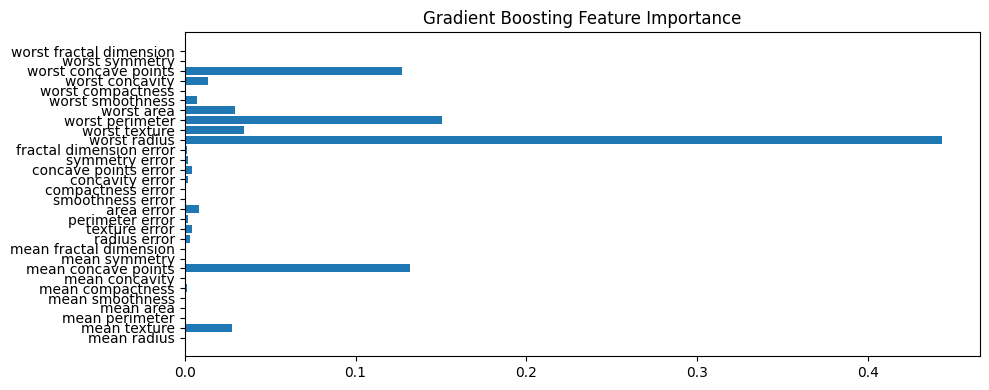

In [6]:
# ランダムフォレストと勾配ブースティングの学習
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

rf.fit(X_std, y)
gb.fit(X_std, y)

# 特徴量重要度の表示
plt.figure(figsize=(10, 4))
plt.barh(feature_names, rf.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.barh(feature_names, gb.feature_importances_)
plt.title("Gradient Boosting Feature Importance")
plt.tight_layout()
plt.show()

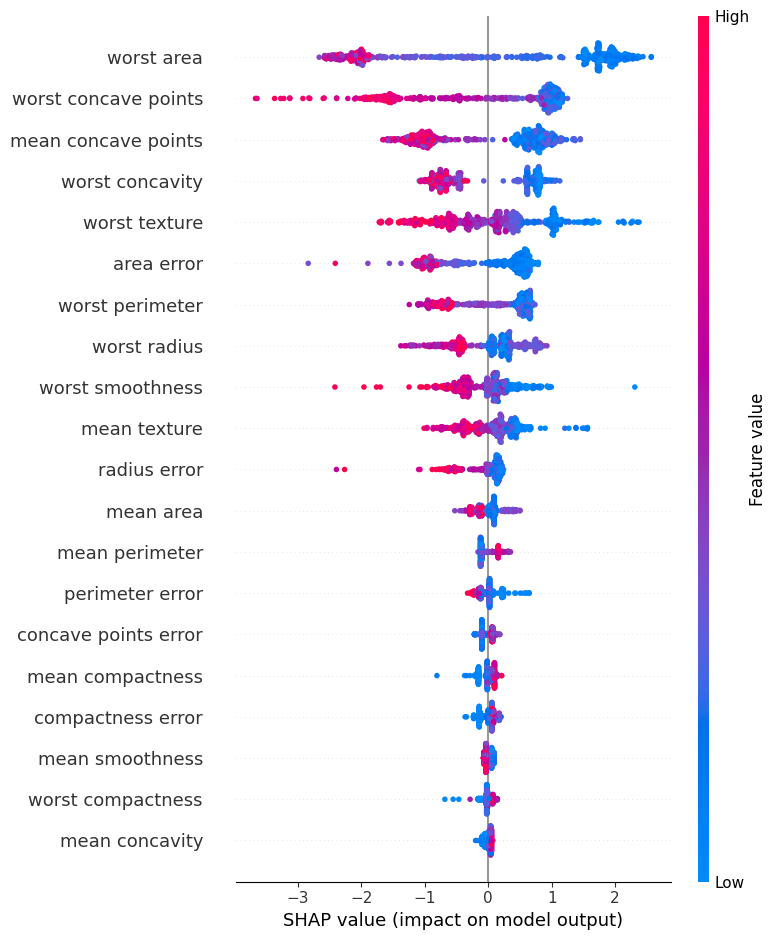

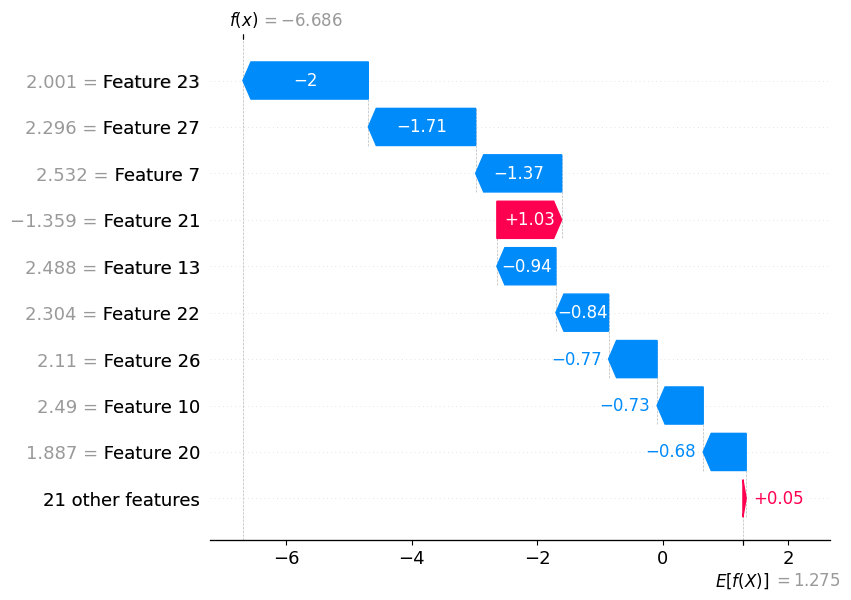

In [7]:
# SHAP値の可視化
import shap

# Gradient Boosting に対して SHAP 実行（TreeExplainer）
explainer = shap.Explainer(gb, X_std)
shap_values = explainer(X_std)

# サマリープロット（グローバルな重要度）
shap.summary_plot(shap_values, X_std, feature_names=feature_names)

# ウォーターフォールプロット（局所的説明）
shap.plots.waterfall(shap_values[0], max_display=10)

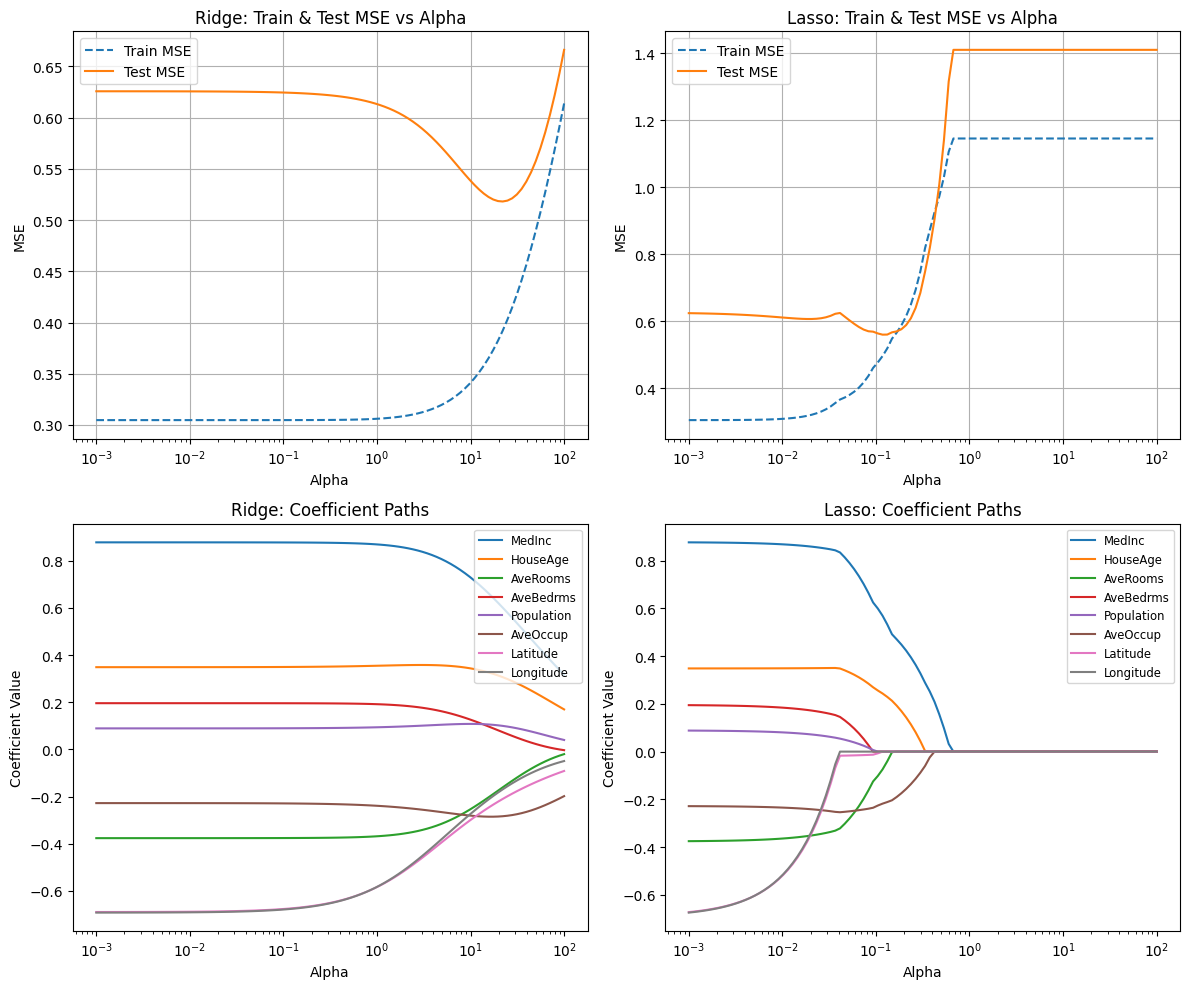

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# データの読み込み
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

# 学習・テストデータの選択
k, m = 100, 300
np.random.seed(42)
indices = np.random.permutation(len(X))
train_idx, test_idx = indices[:k], indices[k:k + m]
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# 標準化
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# 正則化パラメータ
alphas = np.logspace(-3, 2, 100)

# RidgeとLassoの誤差と係数追跡
ridge_mse_train, ridge_mse_test = [], []
lasso_mse_train, lasso_mse_test = [], []
ridge_coefs, lasso_coefs = [], []

for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_train_std, y_train)
    lasso = Lasso(alpha=alpha, max_iter=10000).fit(X_train_std, y_train)
    
    ridge_mse_train.append(mean_squared_error(y_train, ridge.predict(X_train_std)))
    ridge_mse_test.append(mean_squared_error(y_test, ridge.predict(X_test_std)))
    
    lasso_mse_train.append(mean_squared_error(y_train, lasso.predict(X_train_std)))
    lasso_mse_test.append(mean_squared_error(y_test, lasso.predict(X_test_std)))
    
    ridge_coefs.append(ridge.coef_)
    lasso_coefs.append(lasso.coef_)

# プロット
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Ridge: 訓練/テスト MSE
axs[0, 0].plot(alphas, ridge_mse_train, label='Train MSE', linestyle='--')
axs[0, 0].plot(alphas, ridge_mse_test, label='Test MSE')
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlabel('Alpha')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].set_title('Ridge: Train & Test MSE vs Alpha')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Lasso: 訓練/テスト MSE
axs[0, 1].plot(alphas, lasso_mse_train, label='Train MSE', linestyle='--')
axs[0, 1].plot(alphas, lasso_mse_test, label='Test MSE')
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlabel('Alpha')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].set_title('Lasso: Train & Test MSE vs Alpha')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Ridge: 係数パス
axs[1, 0].plot(alphas, ridge_coefs)
axs[1, 0].set_xscale('log')
axs[1, 0].set_xlabel('Alpha')
axs[1, 0].set_ylabel('Coefficient Value')
axs[1, 0].set_title('Ridge: Coefficient Paths')
axs[1, 0].legend(feature_names, loc='best', fontsize='small')

# Lasso: 係数パス
axs[1, 1].plot(alphas, lasso_coefs)
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlabel('Alpha')
axs[1, 1].set_ylabel('Coefficient Value')
axs[1, 1].set_title('Lasso: Coefficient Paths')
axs[1, 1].legend(feature_names, loc='best', fontsize='small')

plt.tight_layout()
plt.show()


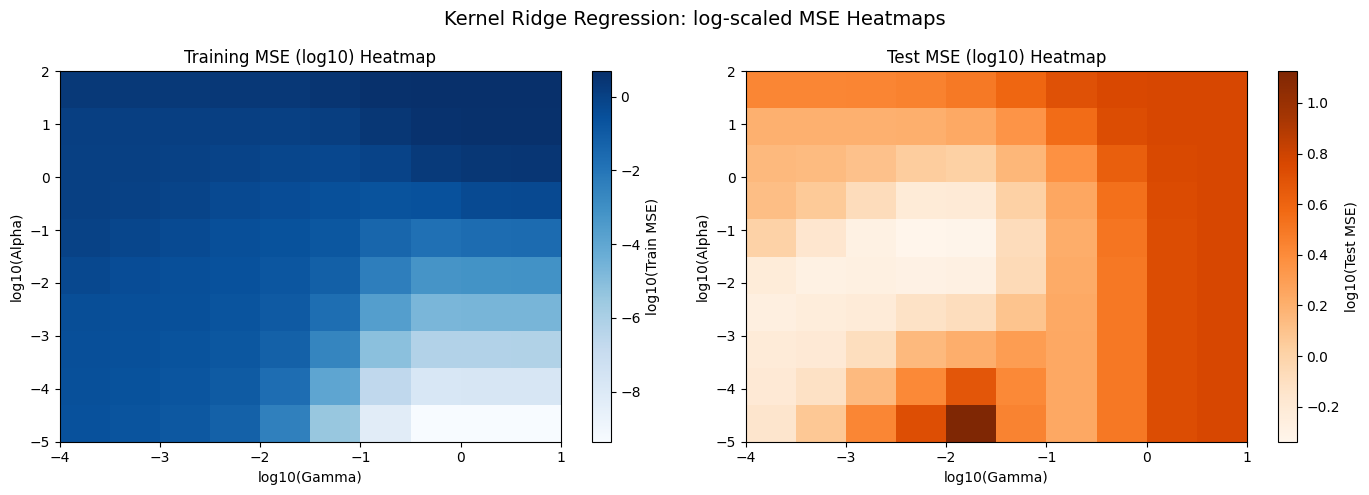

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# データの読み込み
data = fetch_california_housing()
X, y = data.data, data.target

# 学習・テストデータの選択
k, m = 100, 300
np.random.seed(42)
indices = np.random.permutation(len(X))
train_idx, test_idx = indices[:k], indices[k:k + m]
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# 標準化
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# ハイパーパラメータのグリッド
alphas = np.logspace(-5, 2, 10)
gammas = np.logspace(-4, 1, 10)

# 誤差の格納用
train_errors = np.zeros((len(alphas), len(gammas)))
test_errors = np.zeros((len(alphas), len(gammas)))

# モデルの学習と評価
for i, alpha in enumerate(alphas):
    for j, gamma in enumerate(gammas):
        model = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
        model.fit(X_train_std, y_train)
        y_train_pred = model.predict(X_train_std)
        y_test_pred = model.predict(X_test_std)
        train_errors[i, j] = mean_squared_error(y_train, y_train_pred)
        test_errors[i, j] = mean_squared_error(y_test, y_test_pred)

# log10変換
log_train_errors = np.log10(train_errors)
log_test_errors = np.log10(test_errors)

# ヒートマップの描画
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 訓練誤差（対数表示）
im1 = axs[0].imshow(log_train_errors, origin='lower', aspect='auto',
                    extent=[np.log10(gammas[0]), np.log10(gammas[-1]),
                            np.log10(alphas[0]), np.log10(alphas[-1])],
                    cmap='Blues')
axs[0].set_title("Training MSE (log10) Heatmap")
axs[0].set_xlabel("log10(Gamma)")
axs[0].set_ylabel("log10(Alpha)")
plt.colorbar(im1, ax=axs[0], label="log10(Train MSE)")

# テスト誤差（対数表示）
im2 = axs[1].imshow(log_test_errors, origin='lower', aspect='auto',
                    extent=[np.log10(gammas[0]), np.log10(gammas[-1]),
                            np.log10(alphas[0]), np.log10(alphas[-1])],
                    cmap='Oranges')
axs[1].set_title("Test MSE (log10) Heatmap")
axs[1].set_xlabel("log10(Gamma)")
axs[1].set_ylabel("log10(Alpha)")
plt.colorbar(im2, ax=axs[1], label="log10(Test MSE)")

plt.suptitle("Kernel Ridge Regression: log-scaled MSE Heatmaps", fontsize=14)
plt.tight_layout()
plt.show()

Accuracy: 0.9122807017543859

Classification Report:
              precision    recall  f1-score   support

   malignant       0.85      0.93      0.89        42
      benign       0.96      0.90      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



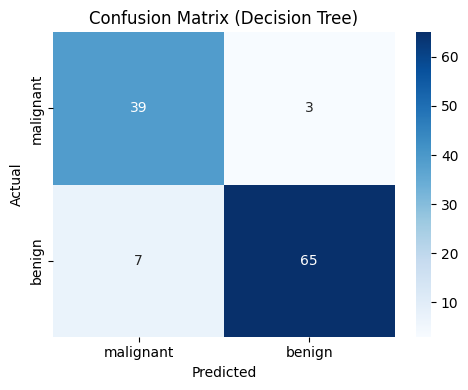

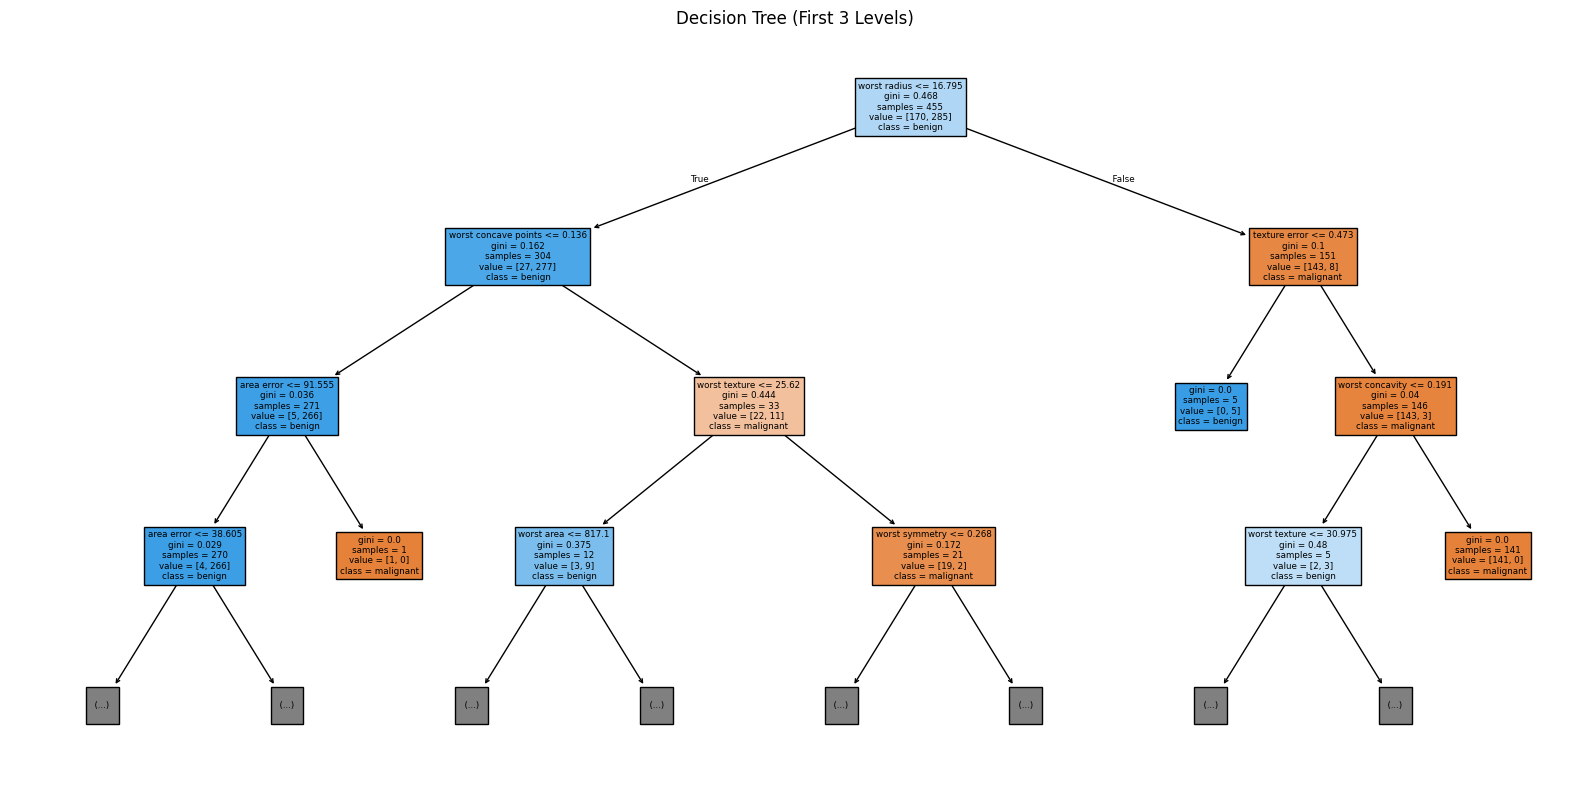

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# データ読み込み
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
target_names = data.target_names

# 訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 決定木モデルの構築（深さ無制限）
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# テストデータで予測・評価
y_pred = tree_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# 混同行列の可視化
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.tight_layout()
plt.show()

# 決定木の可視化（最初の3階層）
plt.figure(figsize=(16, 8))
plot_tree(tree_clf, feature_names=feature_names, class_names=target_names, filled=True, max_depth=3)
plt.title("Decision Tree (First 3 Levels)")
plt.tight_layout()
plt.show()


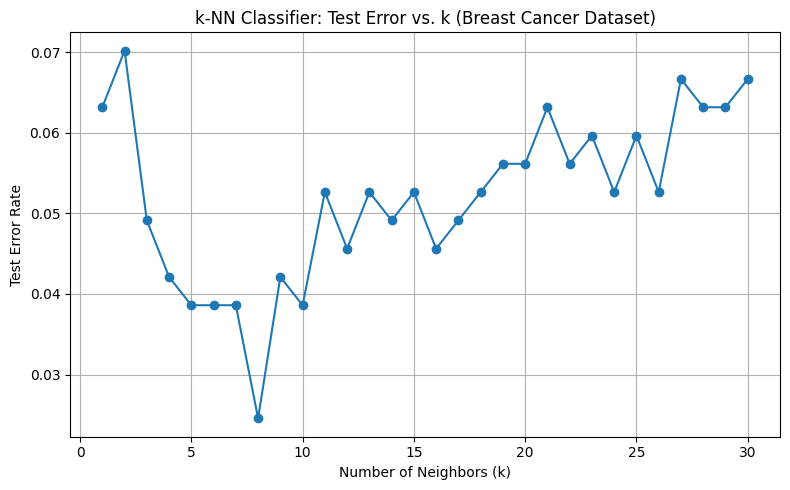

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# データの読み込み
data = load_breast_cancer()
X, y = data.data, data.target

# 訓練・テストに分割（層化抽出）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, random_state=42
)

# 特徴量の標準化
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# kを変化させたときのテスト誤差を計算
k_values = range(1, 31)
test_errors = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    test_error = 1 - accuracy_score(y_test, y_pred)
    test_errors.append(test_error)

# 結果のプロット
plt.figure(figsize=(8, 5))
plt.plot(k_values, test_errors, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Test Error Rate")
plt.title("k-NN Classifier: Test Error vs. k (Breast Cancer Dataset)")
plt.grid(True)
plt.tight_layout()
plt.show()


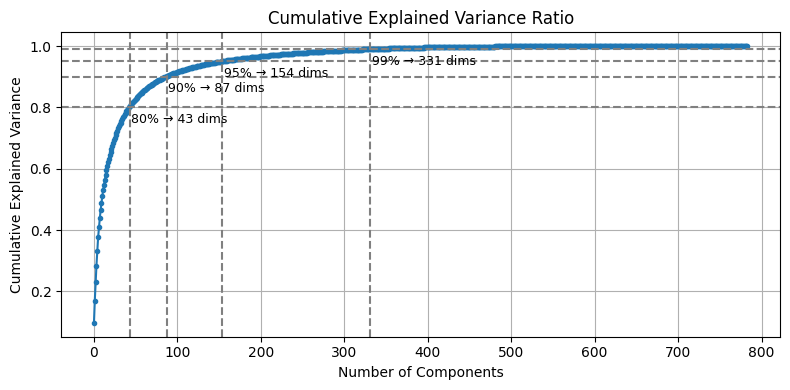

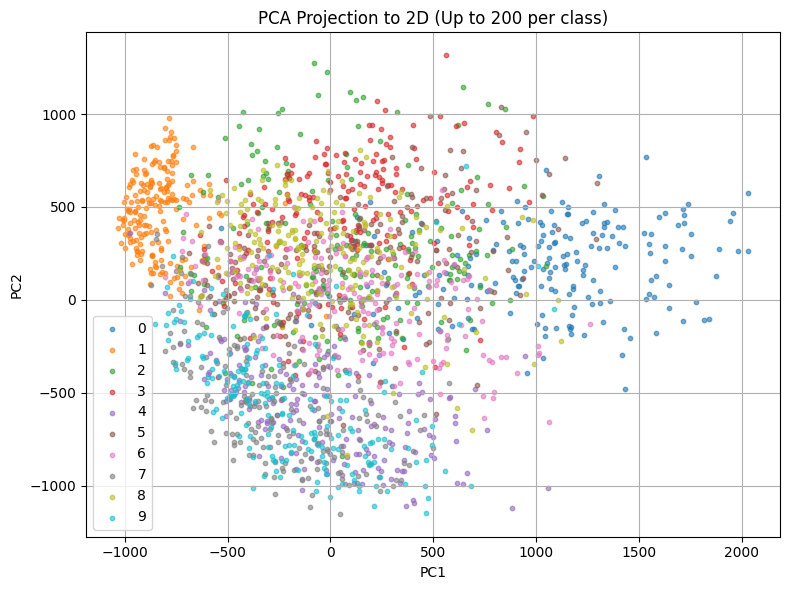

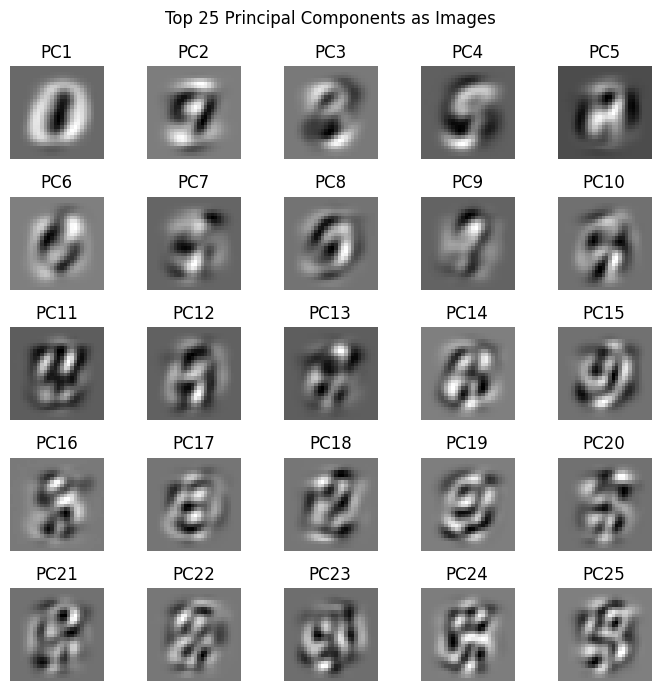

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from collections import defaultdict

# 1. MNIST データの読み込み
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

### 標準化が必要な場合はコメントを外す
# # 2. 標準化
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# 3. PCAの実行
pca = PCA()
# X_pca = pca.fit_transform(X_std) # 標準化を行う場合
X_pca = pca.fit_transform(X) # 標準化を行わない場合

# 4. 累積寄与率のプロット
cum_var_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(cum_var_ratio, marker='.')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Ratio")

# 閾値をマーク
for threshold in [0.80, 0.90, 0.95, 0.99]:
    d = np.argmax(cum_var_ratio >= threshold) + 1
    plt.axhline(y=threshold, color='gray', linestyle='--')
    plt.axvline(x=d, color='gray', linestyle='--')
    plt.text(d + 2, threshold - 0.05, f"{threshold*100:.0f}% → {d} dims", fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()

# 5. PC1-PC2 のプロット（各クラスごとに n_samples 表示）
n_per_class = 200  # 各クラス表示数
class_data = defaultdict(list)
indices = []

for i, label in enumerate(y):
    if len(class_data[label]) < n_per_class:
        class_data[label].append(i)
        indices.append(i)
    if len(indices) >= 10 * n_per_class:
        break

X_proj = X_pca[indices, :2]
y_proj = y[indices]

plt.figure(figsize=(8, 6))
for digit in range(10):
    mask = y_proj == digit
    plt.scatter(X_proj[mask, 0], X_proj[mask, 1], label=f"{digit}", alpha=0.6, s=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA Projection to 2D (Up to {n_per_class} per class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. 主成分基底（固有ベクトル）を画像として表示（最初の 25 個）
n_components_to_show = 25
image_shape = (28, 28)

components = pca.components_[:n_components_to_show]

fig, axs = plt.subplots(5, 5, figsize=(7, 7))
for i, ax in enumerate(axs.ravel()):
    comp_img = components[i].reshape(image_shape)
    comp_img = (comp_img - comp_img.min()) / (comp_img.max() - comp_img.min())  # 0-1 に正規化
    ax.imshow(comp_img, cmap='gray')
    ax.set_title(f"PC{i+1}")
    ax.axis('off')

plt.suptitle("Top 25 Principal Components as Images")
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from collections import defaultdict

# 1. MNIST データの読み込み
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# 2. 各クラスから n_per_class 個ずつサンプリング
n_per_class = 200
class_indices = defaultdict(list)
selected_indices = []

for i, label in enumerate(y):
    if len(class_indices[label]) < n_per_class:
        class_indices[label].append(i)
        selected_indices.append(i)
    if len(selected_indices) >= 10 * n_per_class:
        break

X_sub = X[selected_indices]
y_sub = y[selected_indices]

# 3. 標準化
scaler = StandardScaler()
X_sub_std = scaler.fit_transform(X_sub)

# 4. t-SNE の実行
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_sub_std)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


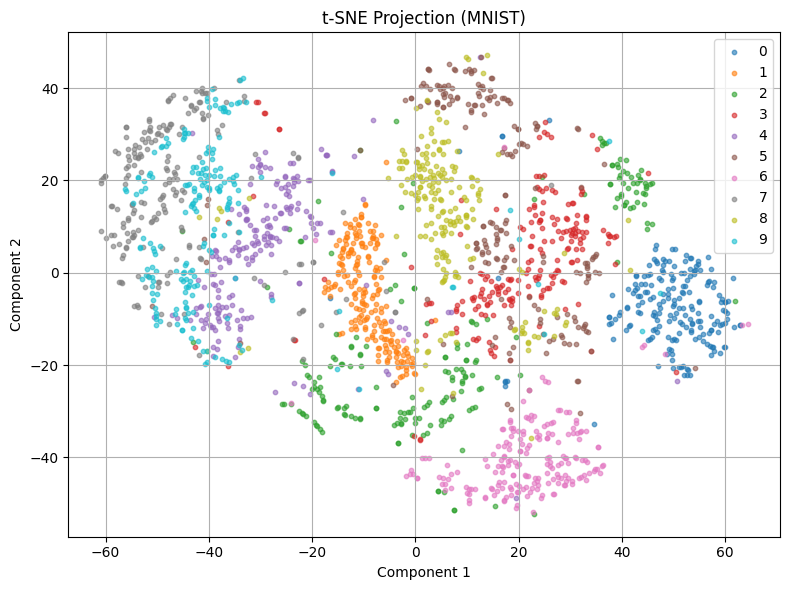

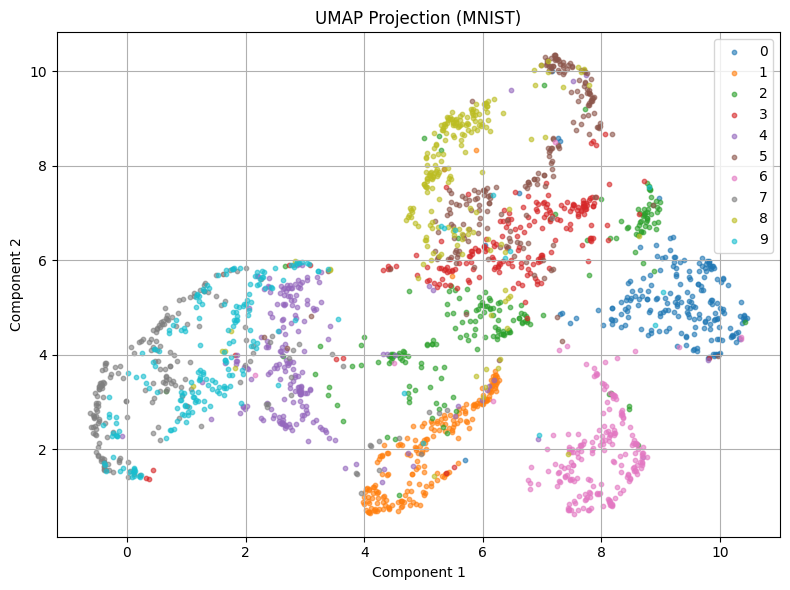

In [12]:
# 5. UMAP の実行
import umap.umap_ as umap
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_sub_std)

# 6. 可視化関数（共通化）
def plot_embedding(X_emb, title, y_labels):
    plt.figure(figsize=(8, 6))
    for digit in range(10):
        mask = y_labels == digit
        plt.scatter(X_emb[mask, 0], X_emb[mask, 1], label=str(digit), s=10, alpha=0.6)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7. 結果の可視化
plot_embedding(X_tsne, "t-SNE Projection (MNIST)", y_sub)
plot_embedding(X_umap, "UMAP Projection (MNIST)", y_sub)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


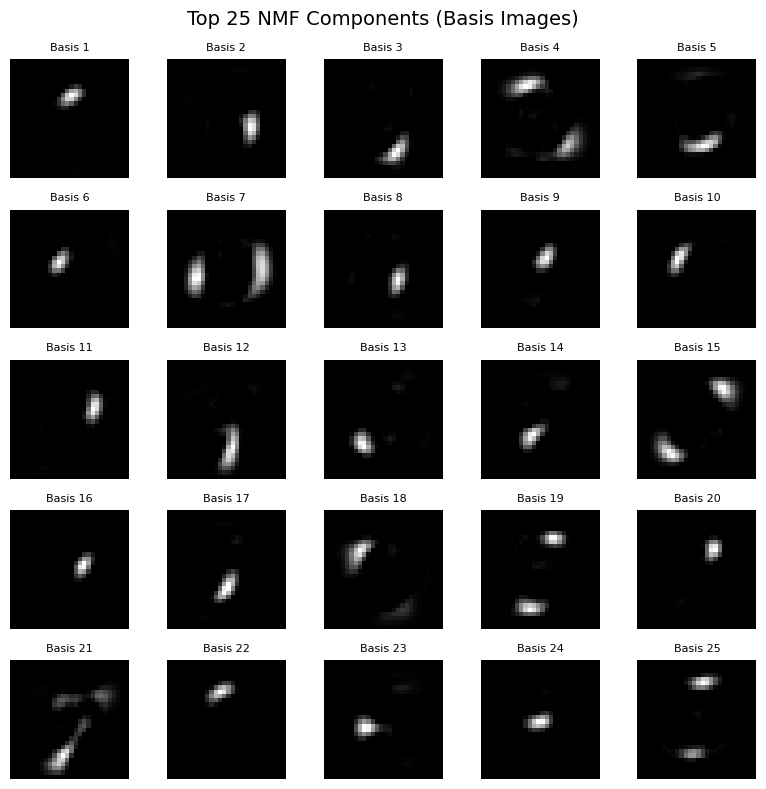

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

# 1. MNISTデータの読み込み
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, _ = mnist.data, mnist.target

# 2. 入力データのスケーリング（NMFは非負制約あり）
# 元データは 0〜255 の画素値：そのままでもOKだが、0〜1にスケーリングすると安定
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. NMFの実行（25次元に圧縮）
n_components = 25
nmf = NMF(n_components=n_components, init='nndsvda', random_state=42)
W = nmf.fit_transform(X_scaled)
H = nmf.components_  # shape: (25, 784)

# 4. 基底ベクトル（Hの各行）を画像として表示
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i, ax in enumerate(axs.ravel()):
    component = H[i].reshape(28, 28)
    ax.imshow(component, cmap='gray')
    ax.set_title(f"Basis {i+1}", fontsize=8)
    ax.axis('off')

plt.suptitle("Top 25 NMF Components (Basis Images)", fontsize=14)
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


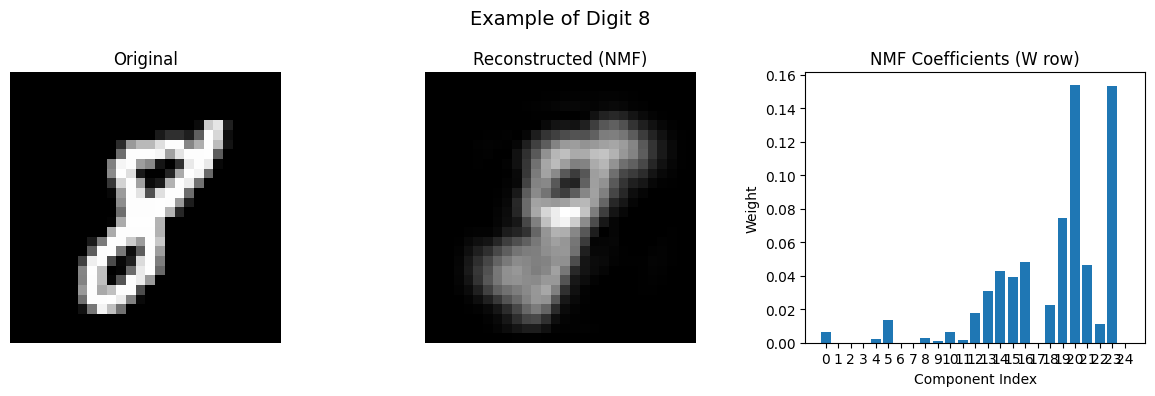

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

# 1. MNIST データの読み込み
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# 2. 0〜1 にスケーリング
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. NMF 実行（前の結果と一致させる）
n_components = 25
nmf = NMF(n_components=n_components, init='nndsvda', random_state=42)
W = nmf.fit_transform(X_scaled)
H = nmf.components_

# 4. 特定の数字（例：「8」）のインデックス取得
target_digit = 8
indices = np.where(y == target_digit)[0][:1]  # 上位5件だけ表示

# 5. 表示処理
for idx in indices:
    original = X_scaled[idx].reshape(28, 28)
    coeffs = W[idx]
    reconstructed = np.dot(coeffs, H).reshape(28, 28)

    # プロット
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("Original")
    axs[0].axis('off')
    
    axs[1].imshow(reconstructed, cmap='gray')
    axs[1].set_title("Reconstructed (NMF)")
    axs[1].axis('off')
    
    axs[2].bar(np.arange(len(coeffs)), coeffs)
    axs[2].set_title("NMF Coefficients (W row)")
    axs[2].set_xlabel("Component Index")
    axs[2].set_ylabel("Weight")
    axs[2].set_xticks(np.arange(len(coeffs)))
    
    plt.suptitle(f"Example of Digit {target_digit}", fontsize=14)
    plt.tight_layout()
    plt.show()


/var/folders/1b/wnqnbfb96xb_197zcy7p8msm0000gn/T/ipykernel_15248/4022223476.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", len(unique_clusters))


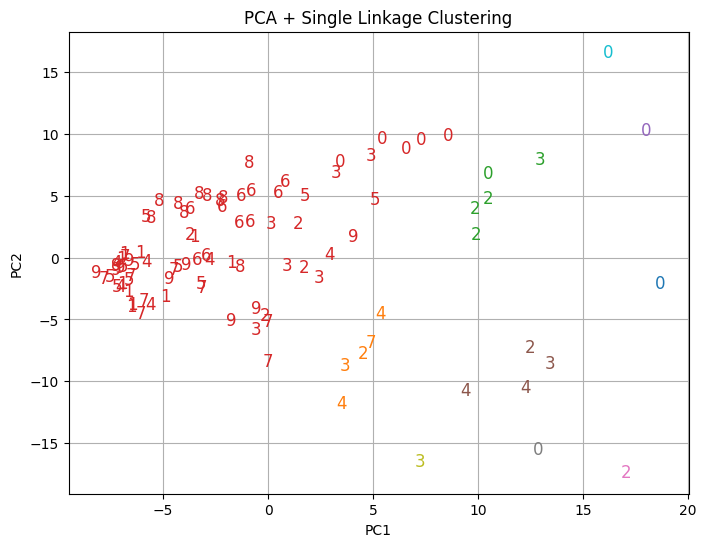

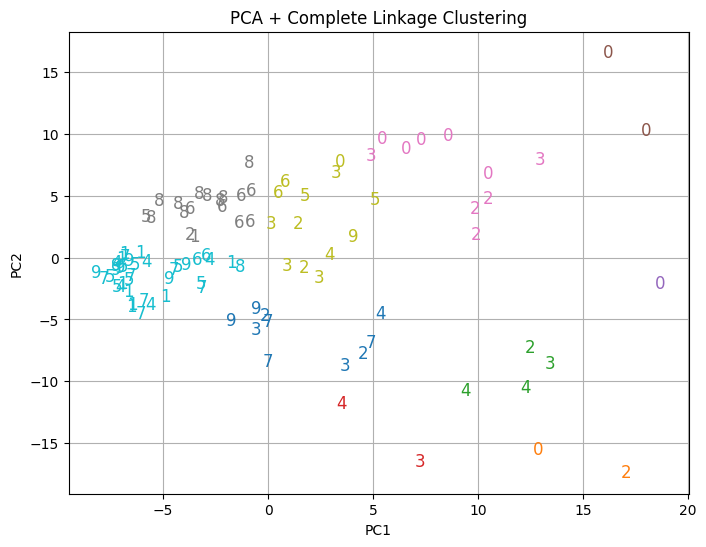

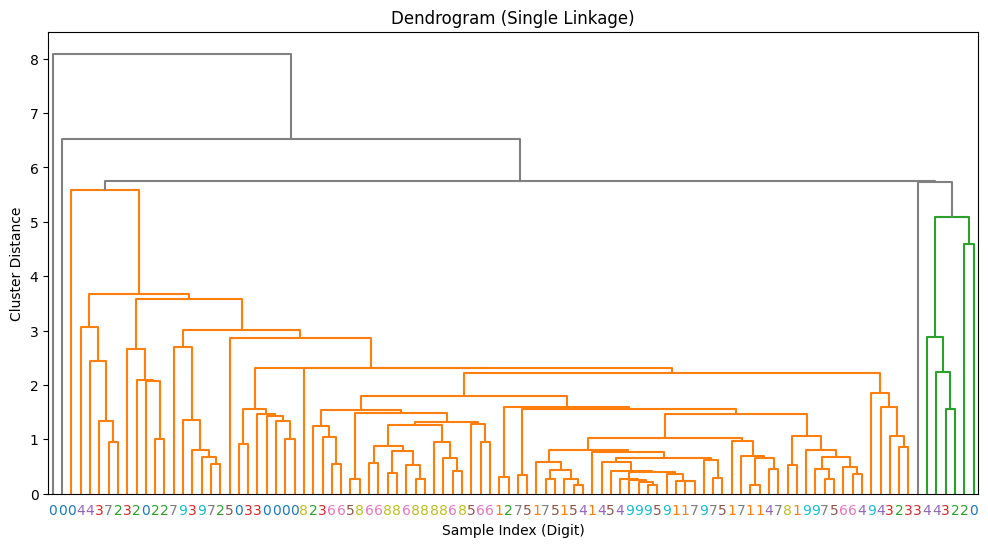

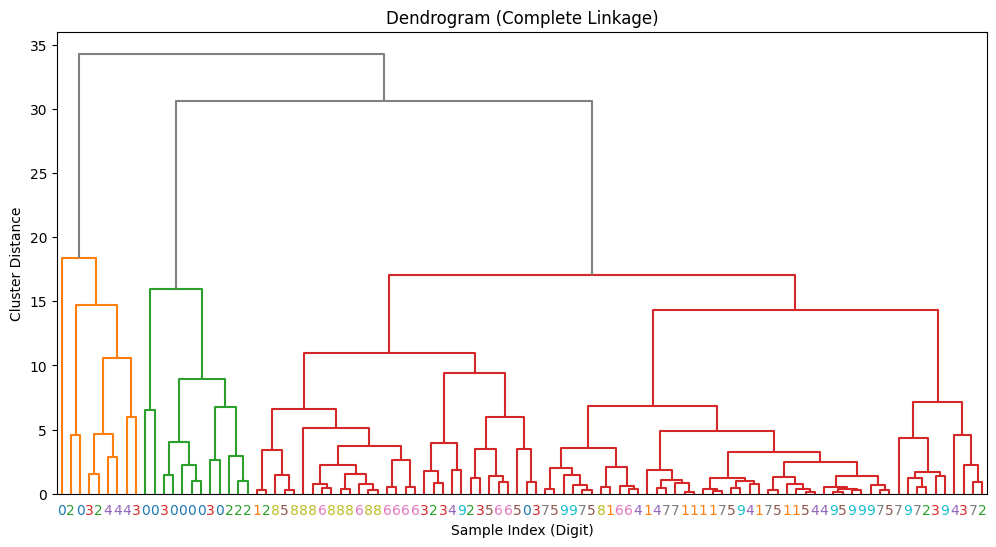

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from collections import defaultdict
import matplotlib.cm as cm

# 1. MNISTの読み込みと抽出（各数字10個ずつ）
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

samples_per_class = 10
selected_indices = []
class_counts = defaultdict(int)

for i, label in enumerate(y):
    if class_counts[label] < samples_per_class:
        selected_indices.append(i)
        class_counts[label] += 1
    if sum(class_counts.values()) >= 10 * samples_per_class:
        break

X_subset = X[selected_indices]
y_subset = y[selected_indices]

# 2. 標準化とPCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. linkage計算とクラスタ（10クラスタに固定）
linkage_single = linkage(X_pca, method='single')
linkage_complete = linkage(X_pca, method='complete')

clusters_single = fcluster(linkage_single, t=10, criterion='maxclust')
clusters_complete = fcluster(linkage_complete, t=10, criterion='maxclust')

# 4. PCA空間でクラスタと文字表示
def plot_clusters(X, labels, clusters, title):
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    plt.figure(figsize=(8, 6))
    unique_clusters = np.unique(clusters)
    colors = cm.get_cmap("tab10", len(unique_clusters))

    # 描画空間を確保するための scatter（透明）
    plt.scatter(X[:, 0], X[:, 1], s=0)  # 表示されないがスケーリングを確保

    # 各点にラベル付きで描画
    for i in range(len(X)):
        plt.text(
            X[i, 0], X[i, 1],
            str(labels[i]),
            color=colors(clusters[i] % 10),
            fontsize=12,
            ha='center', va='center'
        )

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


plot_clusters(X_pca, y_subset, clusters_single, "PCA + Single Linkage Clustering")
plot_clusters(X_pca, y_subset, clusters_complete, "PCA + Complete Linkage Clustering")

# 5. デンドログラムの葉に色付き数字（ラベルによる色分け）
def colored_dendrogram(Z, y_labels, title):
    label_colors = cm.tab10(np.array(y_labels) % 10)

    def llf(id):
        return f"${y_labels[id]}$"

    fig, ax = plt.subplots(figsize=(12, 6))
    dendro = dendrogram(Z, labels=[str(l) for l in y_labels],
#                        color_threshold=0,  # ブランチの色を無効にする
                        above_threshold_color='gray',
                        leaf_rotation=0,
                        leaf_font_size=10,
                        ax=ax)

    # 葉のテキストをラベルごとに色分け
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        digit = int(lbl.get_text())
        lbl.set_color(cm.tab10(digit % 10))

    ax.set_title(title)
    plt.xlabel("Sample Index (Digit)")
    plt.ylabel("Cluster Distance")
    plt.show()

colored_dendrogram(linkage_single, y_subset, "Dendrogram (Single Linkage)")
colored_dendrogram(linkage_complete, y_subset, "Dendrogram (Complete Linkage)")


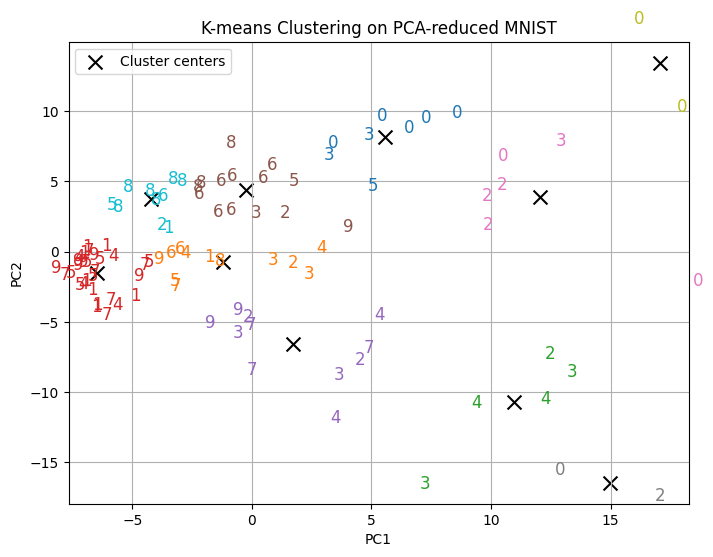

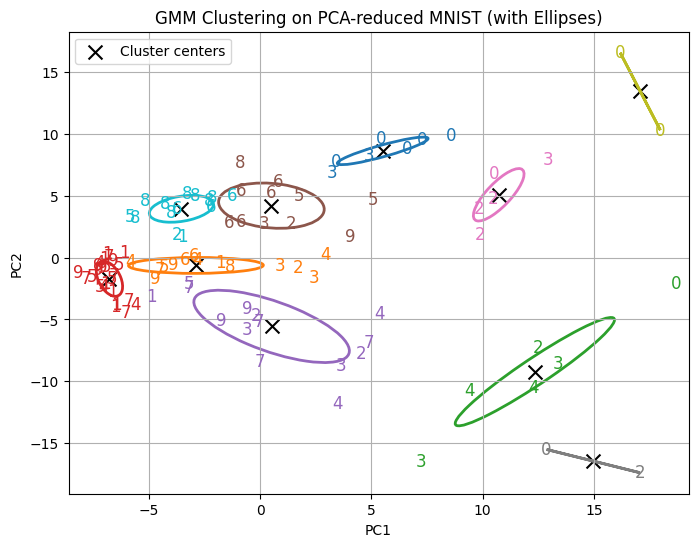

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from collections import defaultdict

# 1. MNIST 読み込み＆各クラス10個抽出
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

samples_per_class = 10
selected_indices = []
class_counts = defaultdict(int)

for i, label in enumerate(y):
    if class_counts[label] < samples_per_class:
        selected_indices.append(i)
        class_counts[label] += 1
    if sum(class_counts.values()) >= 10 * samples_per_class:
        break

X_subset = X[selected_indices]
y_subset = y[selected_indices]

# 2. 標準化＋PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. k-means クラスタリング
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# 4. GMMクラスタリング
gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

# 5. 楕円描画関数（GMM用）
def draw_ellipse(position, covariance, ax, edgecolor):
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        ell = Ellipse(
            xy=position,
            width=width,
            height=height,
            angle=angle,
            edgecolor=edgecolor,
            facecolor='none',
            lw=2
        )
        ax.add_patch(ell)

# 6. 描画関数（数字・色・中心・楕円）
def plot_clusters(X, labels, clusters, centers=None, covariances=None, title=""):
    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap("tab10")
    colors = [cmap(cl % 10) for cl in clusters]

    # 各点を数字で表示
    for i in range(len(X)):
        plt.text(X[i, 0], X[i, 1], str(labels[i]),
                 color=colors[i], fontsize=12,
                 ha='center', va='center')

    # 中心点（代表点）の表示
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1],
                    c='black', s=100, marker='x', label='Cluster centers')

    # GMM 楕円の表示
    if covariances is not None:
        for i in range(k):
            draw_ellipse(centers[i], covariances[i], plt.gca(), edgecolor=cmap(i))

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# 7. 結果表示
plot_clusters(X_pca, y_subset, kmeans_labels,
              centers=kmeans.cluster_centers_,
              title="K-means Clustering on PCA-reduced MNIST")

plot_clusters(X_pca, y_subset, gmm_labels,
              centers=gmm.means_, covariances=gmm.covariances_,
              title="GMM Clustering on PCA-reduced MNIST (with Ellipses)")


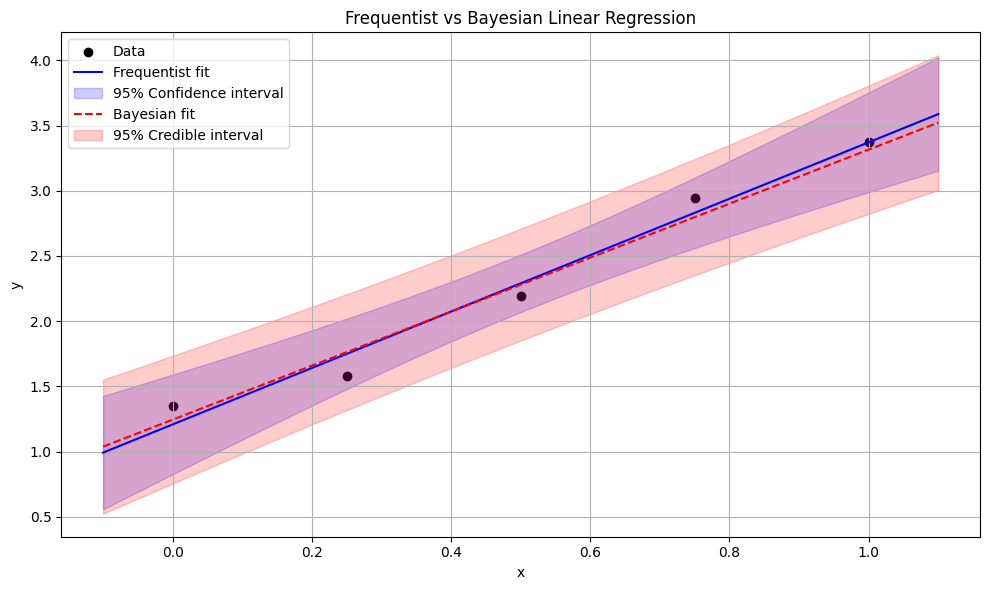

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import t
from numpy.linalg import inv

# データ生成
np.random.seed(0)
n = 5
x = np.linspace(0, 1, n)
X = np.vstack([np.ones_like(x), x]).T
true_w = np.array([1.0, 2.0])
sd = 0.2
y = X @ true_w + np.random.normal(0, sd, size=n)

# 予測用データ
x_test = np.linspace(-0.1, 1.1, 200)
X_test = np.vstack([np.ones_like(x_test), x_test]).T

# -------------------------------
# 頻度主義的線形回帰（信頼区間）
# -------------------------------
linreg = LinearRegression().fit(X, y)
y_pred = linreg.predict(X_test)

# 残差標準偏差
y_train_pred = linreg.predict(X)
residual_std = np.sqrt(np.sum((y - y_train_pred)**2) / (n - 2))

# 信頼区間の計算
XTX_inv = inv(X.T @ X)
tval = t.ppf(0.975, df=n - 2)
conf_int = tval * residual_std * np.sqrt(np.sum((X_test @ XTX_inv) * X_test, axis=1))

# -------------------------------
# ベイズ線形回帰（信用区間）
# -------------------------------
sigma2 = sd ** 2       # 観測ノイズ分散
tau2 = 1.0              # 事前分散

Sigma_inv = (X.T @ X) / sigma2 + np.eye(2) / tau2
Sigma_post = inv(Sigma_inv)
w_post_mean = Sigma_post @ (X.T @ y) / sigma2

y_bayes_mean = X_test @ w_post_mean
y_bayes_std = np.sqrt(sigma2 + np.sum((X_test @ Sigma_post) * X_test, axis=1))
bayes_int = 1.96 * y_bayes_std

# -------------------------------
# 図示
# -------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', color='black')

# 頻度主義の回帰直線と信頼区間
plt.plot(x_test, y_pred, label='Frequentist fit', color='blue')
plt.fill_between(x_test, y_pred - conf_int, y_pred + conf_int,
                 color='blue', alpha=0.2, label='95% Confidence interval')

# ベイズ回帰の平均と信用区間
plt.plot(x_test, y_bayes_mean, label='Bayesian fit', color='red', linestyle='--')
plt.fill_between(x_test, y_bayes_mean - bayes_int, y_bayes_mean + bayes_int,
                 color='red', alpha=0.2, label='95% Credible interval')

plt.title('Frequentist vs Bayesian Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


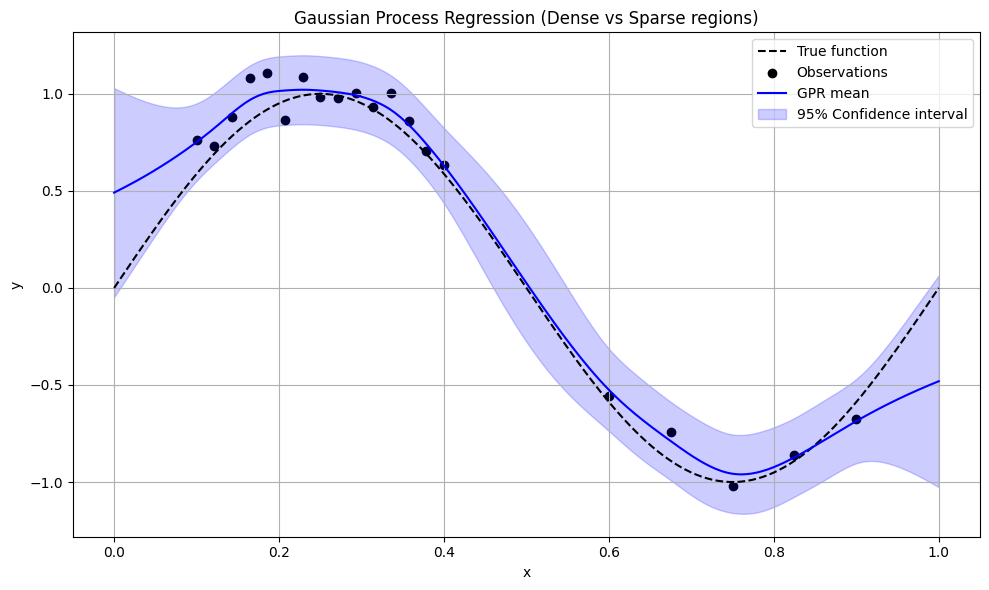

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import Matern

# ---- 人工データ生成 ----
np.random.seed(0)

# 観測点（密な部分と疎な部分を混在）
x_dense = np.linspace(0.1, 0.4, 15)
x_sparse = np.linspace(0.6, 0.9, 5)
x_train = np.concatenate([x_dense, x_sparse])
y_train = np.sin(2 * np.pi * x_train) + np.random.normal(0, 0.1, x_train.shape)

# 入力を2次元化（sklearn の GPR 用）
X_train = x_train.reshape(-1, 1)

# テスト点（予測範囲）
x_test = np.linspace(0, 1, 300).reshape(-1, 1)

# ---- カーネルと GPR モデル定義 ----
#kernel = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
kernel = Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.01)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)

# ---- モデル学習と予測 ----
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(x_test, return_std=True)

# ---- 図示 ----
plt.figure(figsize=(10, 6))
plt.plot(x_test, np.sin(2 * np.pi * x_test), 'k--', label='True function')
plt.scatter(x_train, y_train, color='black', label='Observations')
plt.plot(x_test, y_mean, 'b', label='GPR mean')
plt.fill_between(
    x_test.ravel(), 
    y_mean - 1.96 * y_std, 
    y_mean + 1.96 * y_std, 
    color='blue', alpha=0.2, label='95% Confidence interval'
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Process Regression (Dense vs Sparse regions)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
